# Lab 01: Deep Neural Networks in PyTorch

Author Henrik Horst, opencampus.sh

03.11.2022

At its core, PyTorch is a library for
- doing math on arrays(tensors)
- automatic calculation of gradients (called Autograd)
- acceleration with GPUs and distribution over nodes.

Most of the time,
we work at a remove from the core features of PyTorch,
using abstractions from `torch.nn`
or from frameworks on top of PyTorch.

In [ ]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/GAN_Course"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
  !pwd

In [ ]:
import torch # this is the main PyTorch library
import torchvision #this library belongs also to PyTorch - it is not included in the main lib (import torch) because when you do no vision like for e.g. in language models you do not need it. (Just in case you wondered why it is a separate package)
import pandas as pd

In [ ]:
## reproducibility
random_seed = 1
torch.backends.cudnn.enabled = False ## there are some non-determernistic process in the cuda environment. Don't bother about it know (or probably any time)
torch.manual_seed(random_seed)

## Data is all we need

In ML we always start with data and in PyTorch they invented a really easy and nifty way to handle it well. In PyTorch there is a Dataset class which does all the job. In the beginning of your PyTorch journey it is a bit hard to understand but once you get it you can use it really with easy. So as a start we just load one of the standard datasets in the ML field. The famous MNIST Dataset. This one is already provided out of the box from the torchvision package. So let's start!

In [ ]:
'''
!!! You can completely ignore this cell if you are a beginner !!!
If you're a bit familiar with PyTorch you may wonder why we do not use transforms as in the code below in loading the dataset. This has just educational purposes and you will see
why later in the notebook. I just mention this point here because otherwise naturally questions arise like why is the transform missing. If you are total
beginner just ignore this whole cell. Later you will understand.'''
#don't uncomment for this tutorial
#transform=torchvision.transforms.Compose([
#                               torchvision.transforms.ToTensor(),
#                               torchvision.transforms.Normalize(
#                                 (0.1307,), (0.3081,))
#                             ])

"\n!!! You can completely ignore this cell if you are a beginner !!!\nIf you're a bit familiar with PyTorch you may wonder why we do not use transforms as in the code below in loading the dataset. This has just educational purposes and you will see\nwhy later in the notebook. I just mention this point here because otherwise naturally questions arise like why is the transform missing. If you are total\nbeginner just ignore this whole cell. Later you will understand."

Let's load the MNIST Dataset

In [ ]:
''' So this is really the easy way to load a dataset! I call it here train_dataset but you can call it by which name you want.
As you can see nested in the torchvision package there is a class MNIST which we instantiate (make) here.
This class loads the MNSIT train dataset in your local folder (here: ./data). 
train = True means that you want the training dataset from MNIST -> as you probabily guessed that there must be also then another dataset and you're right the test datatset can be loaded with train=False
download = True means that you also want to download the dataset, when =False it just looks in the directory provided by the root argument (here ./data)
'''
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True)

In [ ]:
type(train_dataset) 

torchvision.datasets.mnist.MNIST

So this is a real PyTorch Dataset now! Later in this course you will learn to build you're own. We can do two things with datasets:
1. Get the items of the the dataset by index
2. Get the length of the dataset that means how many items (i.e. datapoints/examples) it contains 

In [ ]:
# Let's first check the length
len(train_dataset)

60000

So our training dataset contains 60000 examples. Let's get one

In [ ]:
# here we pick the second item (remember indexing starts at 0 )
train_dataset[1]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FE7C38C9850>, 0)

Ok wow what did we get back. Looks for me like a tuple with two entrys.
The first one is an image in the PIL format (just an image format - you might be more familiar with png etc.) and the second one looks like an integer.
So hopefully your intuition says you now that the first entry is the data and the second the corresponding label. 
Let's plot that now:

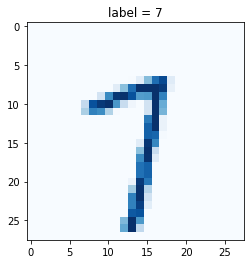

In [ ]:
import matplotlib.pyplot as plt
num_example=42
plt.imshow(train_dataset[num_example][0], interpolation='none', cmap='Blues')
plt.title("label = " + str(train_dataset[num_example][1]))
plt.show()

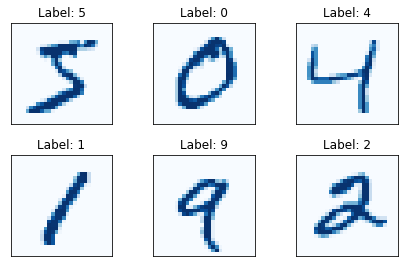

In [ ]:
# and a few more
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_dataset[i][0], interpolation='none', cmap='Blues')
  plt.title(f"Label: {train_dataset[i][1]}")
  plt.xticks([])
  plt.yticks([])

### Task 1


*   Understand everything above!
*   Play with the plottings and find an example which you find hard to classify on your own (as an example look at the index 42 in the dataset
*   What dtype is the label (i.e. integer, float, string????) -> Find out
*   What happens if you access train_dataset[60000] and what is with train_dataset[-1]




## Neural Network

Now that we have our data nicely available. We can feed them in a neural network. Since a neural network needs as an input data in a tensor format we have to convert our PIL image data to tensor data. Normally one does this directly with transforms when loading the dataset and we will do this in the next lab but it is not strictly necessary because we can also do this in the training loop. Let's start.
Every network is implemented in PyTorch by the nn.Module class. So you always define a new class which inherits from nn.Module

In [ ]:
import torch.nn as nn
class Classifier(nn.Module): # Classifier is the name our Network, we are free to choose this name. It could e.g. be als Classifier123.. Inheriting von nn.Module is NOT changeable
  def __init__(self):
    # init mother PyTorch class -> need to do this since we are inheriting from nn.Module
    super().__init__()

    # counter and accumulator for progress during training
    self.counter = 0
    self.losses = []

    # define model
    self.model = nn.Sequential(
      nn.Linear(784, 200),
      nn.Sigmoid(),
      nn.Linear(200, 10),
      nn.Sigmoid()
      )
    # define loss function
    self.loss_function = nn.CrossEntropyLoss()

    # optimizer
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

  def forward(self, inputs):
    # run input through model
    return self.model(inputs)

  def train(self, inputs, targets):
        # calculate the output of the network
        # a nn.Module class is something what is called a callable. This mean that you can treat the class like a function and it then exhibits
        # then the forward pass. We do it below with self(...) since we defined our training loop inside our model class
        input_tensors= torchvision.transforms.ToTensor()(inputs).flatten() # from PIL to tensors -> ToTensor is a callable class that converts the inputs to Tensors
        outputs = self(input_tensors)
        # how self(input_tensors) works is that it just passes the input_tensors to the forward() function defined a bit above. So outputs will be the activations of our last layer in neural network
        

        
        # calculate loss
        loss = self.loss_function(outputs, torch.tensor(targets))
        # our loss the CrossEntropy requieres the targets(i.e. labels) to be integers so we are already all fine because that is exactly how they are saved in our MNIST Dataset

        # increase counter each step and also accumulate error every 1000 steps(batches)
        self.counter += 1
        if (self.counter % 1000 == 0):
            self.losses.append(loss.item())
            
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
    
  def plot_progress(self):
        #df = pd.DataFrame(self.progress, columns=['loss'])
        plt.plot(self.losses, alpha=0.5, marker='.')
        plt.title('loss every 1000 steps')



In [ ]:
%%time 
# create neural network

model = Classifier()

# train network on MNIST data set

epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for image, target in train_dataset:
      # actually we are here feeding in batches of size 1 -> so complete stochastic gradient descent
      model.train(image, target)
        
  

training epoch 1 of 4
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 4
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
training epoch 4 of 4
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
CPU times: user 4min 16s, sys: 55.8 s, total: 5min 12s
Wall time: 5min 20s


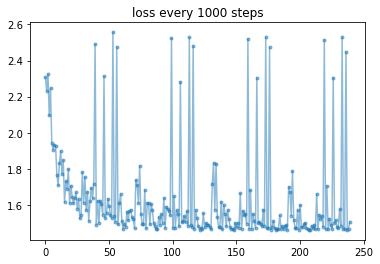

In [ ]:
model.plot_progress()


### Task 2



*   Change the optimizer to Adam
*   Add layers and look at the time the training takes
*   Try to program passing batches into the train funtion






## Test time!!!

In [ ]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True)

In [ ]:
len(test_dataset)

10000

In [ ]:
# test trained neural network on test data

score = 0
items = 0

for image, target in train_dataset:
    prediction = model(torchvision.transforms.ToTensor()(image).flatten()).detach().numpy()
    if (prediction.argmax() == target):
        score += 1
        
    items += 1
    
    

print(f'{score}, {items}, accuracy: {score/items}')

54665, 60000, accuracy: 0.9110833333333334


Let's look a one example to enhance our intuition about the training results

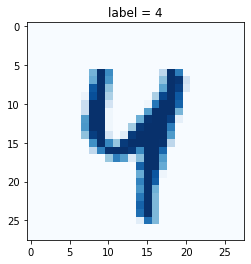

tensor([3.6107e-09, 2.2829e-03, 2.5427e-05, 3.5218e-05, 9.9748e-01, 1.2312e-05,
        2.5391e-05, 2.8577e-03, 1.9359e-02, 2.2673e-01],
       grad_fn=<SigmoidBackward0>)
tensor(1.2488, grad_fn=<SumBackward0>)
tensor([0.0834, 0.0836, 0.0834, 0.0834, 0.2261, 0.0834, 0.0834, 0.0836, 0.0850,
        0.1046], grad_fn=<SoftmaxBackward0>)
tensor(1.0000, grad_fn=<SumBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


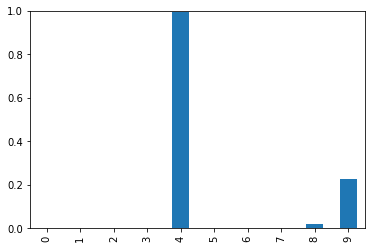

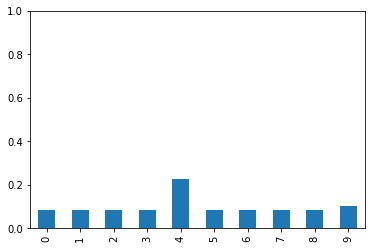

In [ ]:
test_example= 42
plt.imshow(test_dataset[test_example][0], interpolation='none', cmap='Blues')
plt.title("label = " + str(test_dataset[test_example][1]))
plt.show()
test_tensor=torchvision.transforms.ToTensor()(test_dataset[test_example][0]).flatten()

# query from trained network

output = model(test_tensor)
print(output)
print(output.sum()) # outputs add up to more than 1. That is not nice if we want to give the result as a probability like how sure the model is in percent
# plot output tensor
pd.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

#So let's convert our output in probabilities (at least kind of -> these are of course fake probabilities because we artifically make them but they help for human interpretability)
output = torch.nn.functional.softmax(output)

# plot output tensor
pd.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))
print(output)
print(output.sum())

##sorry for the messed up plotting below. I'll see how I can fix that. But nevertheless you can work your way through :)

### Task 3



*   Build some code to compute the accuracy for the training dataset and compare it with the accuracy for the test dataset calculated above


